# Colossus tutorial: halo density profiles

Welcome to the Colossus halo density profile tutorial.

In [1]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

As always with Colossus, we need to set a cosmology.

In [2]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

## Profile basics

The density profile module in Colossus is object-oriented: it contains a base class for all density profiles, and classes for specific models that are derived from the base class. Those derived classes need to implement only one function (density), but can overwrite other functions, for example if there are analytical solutions for quantities that would otherwise need to be computed numerically. At first, we don't need to concern ourselves with this architecture though.

To get started, let's create different density profile predictions for a massive cluster halo at $z = 0$. Profiles can often be initialized by different sets of parameters. For example, an NFW profile can take it's native parameters (central density and scale radius), but can also be initialized using the mass and concentration:

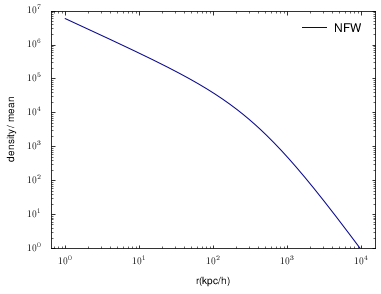

In [3]:
from colossus.halo import profile_nfw

Mvir = 1E15
cvir = 5.0
z = 0.0
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

r = 10**np.arange(0,4,0.02)
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.ylim(1E0, 1E7)
plt.legend();

Note that the Colossus halo module works in physical coordinates. Let's compute the predictions of other profile models for the same halo:

In [4]:
from colossus.halo import profile_einasto
from colossus.halo import profile_diemer22

p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_d22 = profile_diemer22.ModelAProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

rho_einasto = p_einasto.density(r)
rho_d22 = p_d22.density(r)

Let's add the scale radius and virial radius for the NFW profile for clarity. Spherical overdensity radii and masses can be obtained with the `RDelta` and `MDelta` functions. The scale radius is part of the internal parameters of the NFW model, and is thus an entry in the par dictionary that each profile holds:

In [5]:
Rvir_nfw = p_nfw.RDelta(z, 'vir')
print(p_nfw.par)
rs = p_nfw.par['rs']

OrderedDict([('rhos', 1238590.3901771572), ('rs', 406.22619713162084)])


The contents of this dictionary will vary between profile models. For example, for the Einasto profile, it also contains the $\alpha$ parameter which determines how fast the profile steepens:

In [6]:
print(p_einasto.par)

OrderedDict([('rhos', 320857.87721592584), ('rs', 406.22619713162084), ('alpha', 0.2499466732854373)])


Anyway, let's put all of that into a plot:

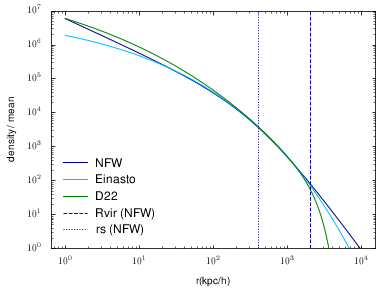

In [7]:
plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.plot(r, rho_einasto / rho_m, '-', label = 'Einasto');
plt.plot(r, rho_d22 / rho_m, '-', label = 'D22');
plt.axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
plt.axvline(rs, ls = ':', label = 'rs (NFW)');
plt.ylim(1E0, 1E7)
plt.legend();

Of course, we can plot numerous quantities other than density, for example surface density. Please see the [documentation of the HaloDensityProfile](https://bdiemer.bitbucket.io/colossus/halo_profile_base.html) base class for an exhaustive list.

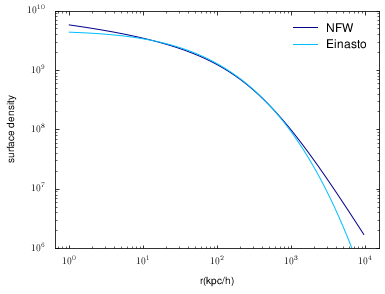

In [8]:
Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_einasto = p_einasto.surfaceDensity(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_einasto, '-', label = 'Einasto');
plt.ylim(1E6, 1E10)
plt.legend();

## The outer (infalling or 2-halo) profile

The differences between profiles in the plot above are mostly apparent at small and large radii. But at large radii, the profile becomes complicated due to non-linear infall and the contribution from other halos (the 2-halo term). In Colossus, multiple such components can be added to a single inner (1-halo) profile. There are two methods. First, we can create objects for the outer terms and add them when constructing the inner profile:

In [9]:
from colossus.halo import profile_outer

outer_term_mean = profile_outer.OuterTermMeanDensity(z = z)
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_terms = [outer_term_mean])

Note that if the same outer term is used in multiple profiles, it should always be copied! Second, there is a more convenient option via a wrapper function:

In [10]:
from colossus.halo import profile_composite

p_nfw = profile_composite.compositeProfile('nfw', outer_names = ['mean'], M = Mvir, c = cvir, z = z, mdef = 'vir')

In this case, we did not need to give additional parameters for the outer terms, but that is not always the case. In general, all parameters expected by the constructors of the inner and outer profiles need to be passed. For example, we can create a more intricate power-law infalling profile:

In [11]:
p_inf = profile_composite.compositeProfile('nfw', outer_names = ['mean'], M = Mvir, c = cvir, z = z, mdef = 'vir',
                                              pl_delta_1 = 10.0, pl_s = 1.4)

Another possible form is to use the matter-matter correlation function times a bias, which we can compute from models such as [Tinker et al. 2010](http://adsabs.harvard.edu/abs/2010ApJ...724..878T):

In [12]:
from colossus.lss import bias
b = bias.haloBias(Mvir, z, 'vir')
print(b)
p_bias = profile_composite.compositeProfile('nfw', outer_names = ['cf'], M = Mvir, c = cvir, z = z, mdef = 'vir', bias = b)

6.066477122593774


In general, the meaning of all parameters is documented in the respective classes. We can compare the impact of the outer profiles in a plot, here using an Einasto profile and different combinations of outer terms:

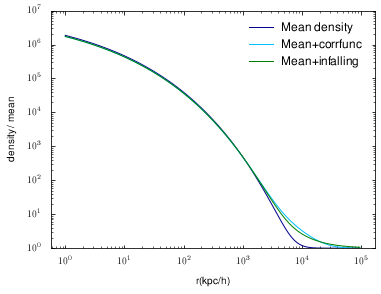

In [13]:
kwargs = dict(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_mean = profile_composite.compositeProfile('einasto', outer_names = ['mean'], **kwargs)
p_cf = profile_composite.compositeProfile('einasto', outer_names = ['mean', 'cf'], bias = b, **kwargs)
p_inf = profile_composite.compositeProfile('einasto', outer_names = ['mean', 'infalling'], pl_delta_1 = 10.0, pl_s = 1.4, **kwargs)

r = 10**np.arange(0,5,0.02)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, p_mean.density(r) / rho_m, '-', label = 'Mean density');
plt.plot(r, p_cf.density(r) / rho_m, '-', label = 'Mean+corrfunc');
plt.plot(r, p_inf.density(r) / rho_m, '-', label = 'Mean+infalling');
plt.ylim(1E0, 1E7)
plt.legend();

The differences in the outer profiles are more apparent if we plot the slope instead:

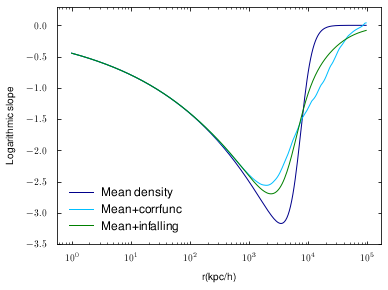

In [14]:
plt.figure()
plt.xscale('log')
plt.xlabel('r(kpc/h)')
plt.ylabel('Logarithmic slope')
plt.plot(r, p_mean.densityDerivativeLog(r), '-', label = 'Mean density');
plt.plot(r, p_cf.densityDerivativeLog(r), '-', label = 'Mean+corrfunc');
plt.plot(r, p_inf.densityDerivativeLog(r), '-', label = 'Mean+infalling');
plt.ylim(-3.5, 0.3)
plt.legend();

## Profile fitting

Let's generate an NFW profile of surface density and some scattered fake data round it. We add an infalling outer profile for this demonstration, but of course everything works the same (in fact, a little more simply) without any outer terms. For example, we do not want the outer term to depend on other fit parameters. Thus, we change the default pivot radius from R200m (which depends on all parameters!) to a fixed length corresponding to Rvir. The normalization (pl_delta_1) now refers to the overdensity of the infalling term at the virial radius.

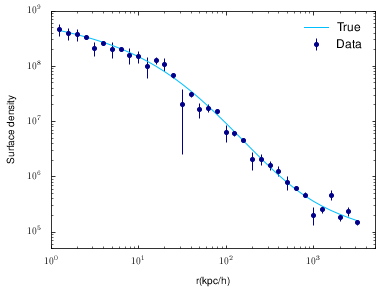

In [15]:
from colossus.halo import mass_so

Mvir = 1E12
cvir = 7.0
Rvir = mass_so.M_to_R(Mvir, z, 'vir')
p = profile_composite.compositeProfile('nfw', outer_names = ['infalling'], M = Mvir, c = cvir, z = 0.0, mdef = 'vir', 
                            pl_delta_1 = 4.0, pl_s = 1.4, pivot = 'fixed', pivot_factor = Rvir)

# Generate random scatter around the true surface density profile
r = 10**np.arange(0.1, 3.6, 0.1)
sigma_true = p.surfaceDensity(r)
np.random.seed(155)
sigma_err = np.abs(np.random.normal(0.2, 0.1, (len(r)))) * sigma_true
sigma = sigma_true.copy()
for i in range(len(r)):
    sigma[i] += np.random.normal(0.0, sigma_err[i])

plt.figure()
plt.loglog()
plt.xlim(1E0, 5E3)
plt.ylim(5E4, 1E9)
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'True')
plt.legend()
plt.errorbar(r, sigma, yerr = sigma_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.legend();

Before we fit the fake data, we need to understand the free parameters of the combined NFW + infalling profile. It is easiest to just print the parameter dictionary:

In [16]:
print(p.par)

OrderedDict([('rhos', 2644694.4869238376), ('rs', 29.01615693797292), ('pl_delta_1', 4.0), ('pl_s', 1.4), ('pl_zeta', 0.5), ('pl_delta_max', 100.0)])


The first two parameters are the standard NFW rho_s and r_s, and the next four are the parameters of the infalling profile. We want to vary pl_delta_1 (the normalization at Rvir) and pl_s (the slope), but not pl_zeta (the transition smoothness) or pl_delta_max (the maximum at the center) because these parameters are generally poorly constrained. Thus, we generate a parameter mask. Elements that are False will be held fixed by the fitter:

In [17]:
mask = np.array([True, True, True, True, False, False])

Now let's generate a bad initial guess of the NFW profile, and recover it by fitting. We generate a bad initial guess and set the profile parameters to that guess:

In [18]:
x_true = p.getParameterArray(mask)
print(x_true)
ini_guess = x_true * 1.2
print(ini_guess)
p.setParameterArray(ini_guess, mask = mask)
sigma_ini = p.surfaceDensity(r)

[2.64469449e+06 2.90161569e+01 4.00000000e+00 1.40000000e+00]
[3.17363338e+06 3.48193883e+01 4.80000000e+00 1.68000000e+00]


Now fit the profile to the data. The `fit()` function has many more parameters than can be discussed here. For example, it can handle covariance matrices, use an MCMC instead of least-squares, and fit density, surface density, enclosed mass and so on. The function's outputs are gathered in a single dictionary:

In [19]:
dic = p.fit(r, sigma, 'Sigma', q_err = sigma_err, mask = mask)
sigma_fit = dic['q_fit']

-------------------------------------------------------------------------------------
Profile fit: Varying 4 / 6 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 7 steps. Best-fit parameters:
Parameter       rhos = 2.48e+06 [2.24e+06 .. 2.76e+06]
Parameter         rs = 2.98e+01 [2.82e+01 .. 3.15e+01]
Parameter pl_delta_1 = 4.23e+00 [2.34e+00 .. 7.64e+00]
Parameter       pl_s = 1.43e+00 [1.29e+00 .. 1.58e+00]
chi2 / Ndof = 35.1 / 31 = 1.13
-------------------------------------------------------------------------------------


The fitter output tells us that the chi2/Ndof is close to unity, as expected. We have recovered the input parameters quite exactly, although the outer profile can be hard to infer from the limited data, leading to some deviations from the input normalization and slope. We also get error estimates and a lot of other output. Let's put it all together in a plot:

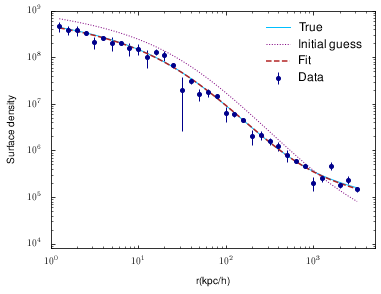

In [20]:
plt.figure()
plt.loglog()
plt.xlim(1E0, 5E3)
plt.ylim(8E3, 1E9)
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'True')
plt.plot(r, sigma_ini, ':', color = 'purple', label = 'Initial guess')
plt.plot(r, sigma_fit, '--', color = 'firebrick', lw = 1.5, label = 'Fit')
plt.legend()
plt.errorbar(r, sigma, yerr = sigma_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.legend();

Besides the standard least-squares fit, colossus also has an MCMC fitter (contributed by Andrey Kravtsov). The code below once again creates a fiducial NFW profile with some noise, but this time fits it using both least-squares and MCMC. Due to the large number of evaluations, MCMC fits can get very slow, especially if computationally expensive quantities such as the surface density profile are fit.

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Found analytical derivative function for quantity rho.
Found solution in 7 steps. Best-fit parameters:
Parameter       rhos = 9.54e+05 [7.31e+05 .. 1.25e+06]
Parameter         rs = 4.95e+01 [4.32e+01 .. 5.68e+01]
chi2 / Ndof = 9.1 / 8 = 1.14
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Running MCMC with the following settings:
Number of parameters:                      2
Number of walkers:                       100
Save conv. indicators every:             500
Finish when Gelman-Rubin less than:   0.0100
-------------------------------------------------------------------------------------
Step    100
Step    200
Step    300
Step    400
Step    500, autocorr. time  30.1, GR = [  0.988  0.947]
Step    6

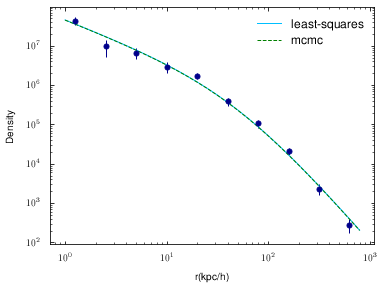

In [21]:
# Create a "true" NFW profile
rhos = 1E6
rs = 50.0
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

# Create a fake dataset with some noise
r = 10**np.arange(0.1, 3.0, 0.3)
rr = 10**np.arange(0.0, 3.0, 0.1)
rho_data = prof.density(r)
sigma = 0.25 * rho_data
np.random.seed(156)
rho_data += np.random.normal(0.0, sigma, len(r))

# Move the profile parameters away from the initial values
prof.setParameterArray([prof.par['rhos'] * 0.4, prof.par['rs'] * 3.0])

# Fit to the fake data using least-squares, compute the fitted profile
prof.fit(r, rho_data, 'rho', q_err = sigma, method = 'leastsq')
rho_fit_leastsq = prof.density(rr)

# Fit to the fake data using MCMC, compute the fitted profile
fit_results = prof.fit(r, rho_data, 'rho', q_err = sigma, method = 'mcmc', convergence_step = 500)
rho_fit_mcmc = prof.density(rr)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('Density')
plt.errorbar(r, rho_data, yerr = sigma, fmt = 'o', ms = 5.0)
plt.plot(rr, rho_fit_leastsq, '-', label = 'least-squares')
plt.plot(rr, rho_fit_mcmc, '--', label = 'mcmc')
plt.legend()
plt.show()

The `fit()` function has returned the full output from the MCMC, including the full and thinned chains. We can plot the latter with this function (copied from the MCMC tutorial):

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

def plotChain(chain, param_labels):
    """
    Plot a summary of an MCMC chain.

    This function creates a triangle plot with a 2D histogram for each combination of parameters,
    and a 1D histogram for each parameter. The plot is not automatically saved or shown, the user
    can determine how to use the plot after executing this function.

    Parameters
    -----------------------------------------------------------------------------------------------
    chain: array_like
        A numpy array of dimensions ``[nsteps, nparams]`` with the parameters at each step in the 
        chain. The chain is created by the :func:`runChain` function.
    param_labels: array_like
        A list of strings which are used when plotting the parameters. 
    """

    nsamples = len(chain)
    nparams = len(chain[0])

    # Prepare panels
    margin_lb = 1.0
    margin_rt = 0.5
    panel_size = 2.5
    size = nparams * panel_size + margin_lb + margin_rt
    fig = plt.figure(figsize = (size, size))
    gs = gridspec.GridSpec(nparams, nparams)
    margin_lb_frac = margin_lb / size
    margin_rt_frac = margin_rt / size
    plt.subplots_adjust(left = margin_lb_frac, bottom = margin_lb_frac, right = 1.0 - margin_rt_frac,
                    top = 1.0 - margin_rt_frac, hspace = margin_rt_frac, wspace = margin_rt_frac)
    panels = [[None for dummy in range(nparams)] for dummy in range(nparams)] 
    for i in range(nparams):
        for j in range(nparams):
            if i >= j:
                pan = fig.add_subplot(gs[i, j])
                panels[i][j] = pan
                if i < nparams - 1:
                    pan.set_xticklabels([])
                else:
                    plt.xlabel(param_labels[j])
                if j > 0:
                    pan.set_yticklabels([])
                else:
                    plt.ylabel(param_labels[i])
            else:
                panels[i][j] = None

    # Plot 1D histograms
    nbins = min(50, nsamples / 20.0)
    minmax = np.zeros((nparams, 2), float)
    for i in range(nparams):
        ci = chain[:, i]
        plt.sca(panels[i][i])
        _, bins, _ = plt.hist(ci, bins = nbins)
        minmax[i, 0] = bins[0]
        minmax[i, 1] = bins[-1]
        diff = minmax[i, 1] - minmax[i, 0]
        minmax[i, 0] -= 0.03 * diff
        minmax[i, 1] += 0.03 * diff
        plt.xlim(minmax[i, 0], minmax[i, 1])

    # Plot 2D histograms
    for i in range(nparams):
        ci = chain[:, i]
        for j in range(nparams):
            cj = chain[:, j]
            if i > j:
                plt.sca(panels[i][j])
                plt.hist2d(cj, ci, bins = 100, norm = LogNorm(), density = True)
                plt.ylim(minmax[i, 0], minmax[i, 1])
                plt.xlim(minmax[j, 0], minmax[j, 1])

    return

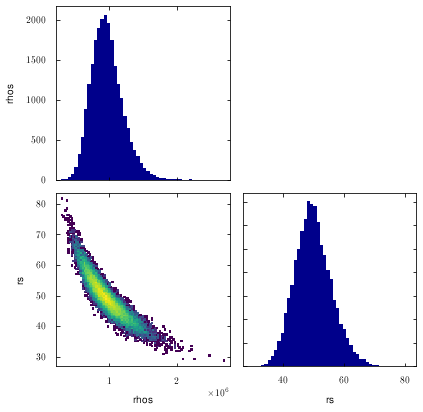

In [23]:
plotChain(fit_results['chain_thin'], ['rhos', 'rs'])

Note that, by default, the MCMC internally runs over the log of the parameters. This can be changed by overwriting certain functions (see below).

## General spline profiles

In addition to the analytical profile forms that we have explored so far, Colossus also offers a generalized profile that can be initialized from a table of density or enclodes mass. Let's test how well this interpolated profile does compared to a "true" NFW profile:

Initializing spline profile from 6 radial bins.


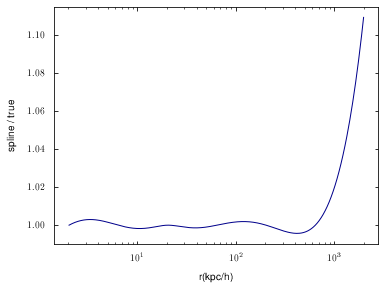

In [24]:
from colossus.halo import mass_so
from colossus.halo import profile_spline

cosmology.setCosmology('planck15')

#Create an NFW profile
mdef = 'vir'
p_nfw = profile_nfw.NFWProfile(M = 1E12, c = 10.0, mdef = mdef, z = 0.0)

# Create a coarse array of radii and evaluate the NFW density
Rvir = mass_so.M_to_R(Mvir, z, mdef)
r = 10**np.arange(-2.0, 1.0, 0.5) * Rvir
rho = p_nfw.density(r)

# Create a spline profile from the radius array
print('Initializing spline profile from %d radial bins.' % (len(r)))
p_spline = profile_spline.SplineProfile(r, rho = rho)

# Now create a much finer array of radii and test how well the spline does
r = 10**np.arange(-2.0, 1.0, 0.01) * Rvir
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)
rho_spline = p_spline.density(r)

plt.figure()
plt.xscale('log')
plt.xlabel('r(kpc/h)')
plt.ylabel('spline / true')
plt.plot(r, rho_spline / rho_nfw, '-');

The spline does surprisingly well, given that we only used 6 bins! But at large radii, we see why we need to be careful with spline profiles: at the boundary, interpolation errors creep in. Thus, we must always make sure to cover a radial range larger than where the profile will be used.

## Creating a new density profile model

While the most commonly used density profile models are implemented in colossus, you may well want to overwrite the HaloDensityProfile base class yourself. For example, let's implement the [Hernquist 1990](http://adsabs.harvard.edu/abs/1990ApJ...356..359H) model (this profile is already implemented in Colossus, but it's a good example anyway):

In [25]:
from colossus.halo import profile_base

class HernquistProfile(profile_base.HaloDensityProfile):

    def __init__(self, **kwargs):

        self.par_names = ['rhos', 'rs']
        self.opt_names = []
        profile_base.HaloDensityProfile.__init__(self, **kwargs)

        return

    def densityInner(self, r):

        x = r / self.par['rs']
        density = self.par['rhos'] / x / (1.0 + x)**3

        return density
    
    def setNativeParameters(self, M, c, z, mdef, **kwargs):

        self.par['rs'] = mass_so.M_to_R(M, z, mdef) / c
        self.par['rhos'] = M / (2 * np.pi * rs**3) / c**2 * (1.0 + c)**2

        return

In the constructor, we had to make the profile class conscious of its internal parameters (central density and scale radius, just as for the NFW profile). This self-awareness is necessary for the fitting routines. The most important function that we must overwrite is `densityInner()`. Moreover, Colossus demands that all profiles have the ability to generate themselves given a mass and concentration. We convert those variables to the "native" variables in `setNativeParameters()`. We can test the new profile by instantiating it in both ways:

In [29]:
Mvir = 1E12
cvir = 7.0
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

p_hernquist1 = HernquistProfile(rhos = p_nfw.par['rhos'], rs = p_nfw.par['rs'])
p_hernquist2 = HernquistProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

Now we can use our new profile object in all the same ways demonstrated above, including all the functionality of the base class. For example, we can evaluate the surface density profile even though we never told our new class how to compute that:

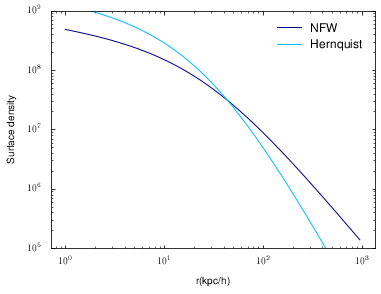

In [28]:
r = 10**np.arange(0,3,0.02)
Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_hernquist = p_hernquist2.surfaceDensity(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_hernquist, '-', label = 'Hernquist');
plt.ylim(1E5, 1E9)
plt.legend();

Note, however, that certain functions might be less accurate or relatively slow. For example, the slope of the density profile would be computed numerically - in the case of the Hernquist profile, it would make sense to overwrite that function using the analytical expression for the slope.

When a profile is intended to be used in fits, it is also recommended to create a `_fitParamDeriv_rho()` function, which returns the derivatives of the profile wrt. the parameters. This speeds up least-squares fitting. Similarly, the `_fitConvertParams()` function gives the user control over transformations to be applied to the profile variables during fitting. For examples of how to use these and other functions, please see the already implemented profile classes. 